In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
!unzip "/content/drive/MyDrive/Data - intern/congenital-heart-disease.zip"

Archive:  /content/drive/MyDrive/Data - intern/congenital-heart-disease.zip
  inflating: ASD/ASD01.jpg           
  inflating: ASD/ASD02.jpg           
  inflating: ASD/ASD03.jpg           
  inflating: ASD/ASD04.jpg           
  inflating: ASD/ASD05.jpg           
  inflating: ASD/ASD06.jpg           
  inflating: ASD/ASD07.jpg           
  inflating: ASD/ASD08.jpg           
  inflating: ASD/ASD09.jpg           
  inflating: ASD/ASD10.jpg           
  inflating: ASD/ASD100.jpg          
  inflating: ASD/ASD101.jpg          
  inflating: ASD/ASD102.jpg          
  inflating: ASD/ASD103.jpg          
  inflating: ASD/ASD104.jpg          
  inflating: ASD/ASD105.jpg          
  inflating: ASD/ASD106.jpg          
  inflating: ASD/ASD107.jpg          
  inflating: ASD/ASD108.jpg          
  inflating: ASD/ASD109.jpg          
  inflating: ASD/ASD11.jpg           
  inflating: ASD/ASD110.jpg          
  inflating: ASD/ASD111.jpg          
  inflating: ASD/ASD112.jpg          
  inflating:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split


In [ ]:
zip_file_path = '/content/drive/MyDrive/Data - intern/congenital-heart-disease.zip'  # Update this path
extract_to_dir = '/content/dataset'  # Update this path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)


In [ ]:
data_dir = '/content/dataset'
train_dir = 'content/dataset1/train'
test_dir = 'content/dataset1/test'

categories = ['ASD', 'Normal', 'PDA', 'VSD']


In [ ]:
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


In [ ]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    files = os.listdir(category_path)

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category, file))

    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category, file))


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define paths
train_path = train_dir
test_path = test_dir


In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='categorical')


Found 661 images belonging to 4 classes.
Found 167 images belonging to 4 classes.


In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

In [ ]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=validation_steps)

Epoch 1/20
21/21 [==============================] - 266s 13s/step - loss: 1.8225 - accuracy: 0.3086 - val_loss: 1.2481 - val_accuracy: 0.4671
Epoch 2/20
21/21 [==============================] - 224s 11s/step - loss: 1.2550 - accuracy: 0.4281 - val_loss: 1.1920 - val_accuracy: 0.4671
Epoch 3/20
21/21 [==============================] - 220s 11s/step - loss: 1.1870 - accuracy: 0.4781 - val_loss: 1.1383 - val_accuracy: 0.5030
Epoch 4/20
21/21 [==============================] - 223s 11s/step - loss: 1.1862 - accuracy: 0.4584 - val_loss: 1.1247 - val_accuracy: 0.5150
Epoch 5/20
21/21 [==============================] - 223s 11s/step - loss: 1.1501 - accuracy: 0.4977 - val_loss: 1.1450 - val_accuracy: 0.5150
Epoch 6/20
21/21 [==============================] - 220s 10s/step - loss: 1.1199 - accuracy: 0.5113 - val_loss: 1.1562 - val_accuracy: 0.5210
Epoch 7/20
21/21 [==============================] - 222s 11s/step - loss: 1.0994 - accuracy: 0.5265 - val_loss: 1.0892 - val_accuracy: 0.5389
Epoch 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=validation_steps)
print('Test accuracy:', test_acc)

6/6 [==============================] - 49s 8s/step - loss: 0.9774 - accuracy: 0.5988
Test accuracy: 0.598802387714386


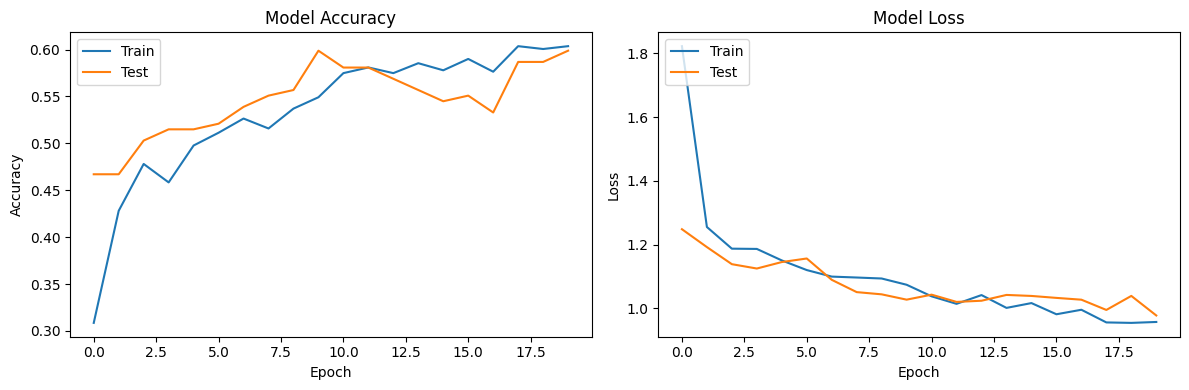

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='categorical')



Found 661 images belonging to 4 classes.
Found 167 images belonging to 4 classes.


In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

In [ ]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze the top layers of the model
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)



In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=40,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.4619 - accuracy: 0.2632 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 670s 32s/step - loss: 1.4619 - accuracy: 0.2632 - val_loss: 1.3943 - val_accuracy: 0.2635 - lr: 1.0000e-04
Epoch 2/40
21/21 [==============================] - 708s 34s/step - loss: 1.3870 - accuracy: 0.2814 - val_loss: 1.3829 - val_accuracy: 0.2515 - lr: 1.0000e-04
Epoch 3/40
21/21 [==============================] - 667s 32s/step - loss: 1.3898 - accuracy: 0.2602 - val_loss: 1.3799 - val_accuracy: 0.2635 - lr: 1.0000e-04
Epoch 4/40
21/21 [==============================] - 703s 34s/step - loss: 1.3866 - accuracy: 0.2708 - val_loss: 1.3720 - val_accuracy: 0.3054 - lr: 1.0000e-04
Epoch 5/40
21/21 [==============================] - 666s 32s/step - loss: 1.3864 - accuracy: 0.2753 - val_loss: 1.3837 - val_accuracy: 0.2455 - lr: 1.0000e-04
Epoch 6/40
21/21 [==============================] - 709s 34s/step - loss: 1.3765 - accuracy: 0.2890 - val_loss: 1.3690 - val_accuracy: 0.3713 - lr: 1.0000e-04
Epoch 7/40
21/21 [==============================] - 701s 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=validation_steps)
print('Test accuracy:', test_acc)


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()
